# Machine Learning Trading Bot

In this Challenge, you’ll assume the role of a financial advisor at one of the top five financial advisory firms in the world. Your firm constantly competes with the other major firms to manage and automatically trade assets in a highly dynamic environment. In recent years, your firm has heavily profited by using computer algorithms that can buy and sell faster than human traders.

The speed of these transactions gave your firm a competitive advantage early on. But, people still need to specifically program these systems, which limits their ability to adapt to new data. You’re thus planning to improve the existing algorithmic trading systems and maintain the firm’s competitive advantage in the market. To do so, you’ll enhance the existing trading signals with machine learning algorithms that can adapt to new data.

## Instructions:

Use the starter code file to complete the steps that the instructions outline. The steps for this Challenge are divided into the following sections:

* Establish a Baseline Performance

* Tune the Baseline Trading Algorithm

* Evaluate a New Machine Learning Classifier

* Create an Evaluation Report

#### Establish a Baseline Performance

In this section, you’ll run the provided starter code to establish a baseline performance for the trading algorithm. To do so, complete the following steps.

Open the Jupyter notebook. Restart the kernel, run the provided cells that correspond with the first three steps, and then proceed to step four. 

1. Import the OHLCV dataset into a Pandas DataFrame.

2. Generate trading signals using short- and long-window SMA values. 

3. Split the data into training and testing datasets.

4. Use the `SVC` classifier model from SKLearn's support vector machine (SVM) learning method to fit the training data and make predictions based on the testing data. Review the predictions.

5. Review the classification report associated with the `SVC` model predictions. 

6. Create a predictions DataFrame that contains columns for “Predicted” values, “Actual Returns”, and “Strategy Returns”.

7. Create a cumulative return plot that shows the actual returns vs. the strategy returns. Save a PNG image of this plot. This will serve as a baseline against which to compare the effects of tuning the trading algorithm.

8. Write your conclusions about the performance of the baseline trading algorithm in the `README.md` file that’s associated with your GitHub repository. Support your findings by using the PNG image that you saved in the previous step.

#### Tune the Baseline Trading Algorithm

In this section, you’ll tune, or adjust, the model’s input features to find the parameters that result in the best trading outcomes. (You’ll choose the best by comparing the cumulative products of the strategy returns.) To do so, complete the following steps:

1. Tune the training algorithm by adjusting the size of the training dataset. To do so, slice your data into different periods. Rerun the notebook with the updated parameters, and record the results in your `README.md` file. Answer the following question: What impact resulted from increasing or decreasing the training window?

> **Hint** To adjust the size of the training dataset, you can use a different `DateOffset` value&mdash;for example, six months. Be aware that changing the size of the training dataset also affects the size of the testing dataset.

2. Tune the trading algorithm by adjusting the SMA input features. Adjust one or both of the windows for the algorithm. Rerun the notebook with the updated parameters, and record the results in your `README.md` file. Answer the following question: What impact resulted from increasing or decreasing either or both of the SMA windows?

3. Choose the set of parameters that best improved the trading algorithm returns. Save a PNG image of the cumulative product of the actual returns vs. the strategy returns, and document your conclusion in your `README.md` file.

#### Evaluate a New Machine Learning Classifier

In this section, you’ll use the original parameters that the starter code provided. But, you’ll apply them to the performance of a second machine learning model. To do so, complete the following steps:

1. Import a new classifier, such as `AdaBoost`, `DecisionTreeClassifier`, or `LogisticRegression`. (For the full list of classifiers, refer to the [Supervised learning page](https://scikit-learn.org/stable/supervised_learning.html) in the scikit-learn documentation.)

2. Using the original training data as the baseline model, fit another model with the new classifier.

3. Backtest the new model to evaluate its performance. Save a PNG image of the cumulative product of the actual returns vs. the strategy returns for this updated trading algorithm, and write your conclusions in your `README.md` file. Answer the following questions: Did this new model perform better or worse than the provided baseline model? Did this new model perform better or worse than your tuned trading algorithm?

#### Create an Evaluation Report

In the previous sections, you updated your `README.md` file with your conclusions. To accomplish this section, you need to add a summary evaluation report at the end of the `README.md` file. For this report, express your final conclusions and analysis. Support your findings by using the PNG images that you created.


In [57]:
# Imports
import pandas as pd
import numpy as np
from pathlib import Path
import hvplot.pandas
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report

---

## Establish a Baseline Performance

In this section, you’ll run the provided starter code to establish a baseline performance for the trading algorithm. To do so, complete the following steps.

Open the Jupyter notebook. Restart the kernel, run the provided cells that correspond with the first three steps, and then proceed to step four. 


### Step 1: mport the OHLCV dataset into a Pandas DataFrame.

In [58]:
# Import the OHLCV dataset into a Pandas Dataframe
ohlcv_df = pd.read_csv(
    Path("./Resources/emerging_markets_ohlcv.csv"), 
    index_col='date', 
    infer_datetime_format=True, 
    parse_dates=True
)

# Review the DataFrame
ohlcv_df.head()

,open,high,low,close,volume
date,,,,,
2015-01-21 09:30:00,23.83,23.83,23.83,23.83,100
2015-01-21 11:00:00,23.98,23.98,23.98,23.98,100
2015-01-22 15:00:00,24.42,24.42,24.42,24.42,100
2015-01-22 15:15:00,24.42,24.44,24.42,24.44,200
2015-01-22 15:30:00,24.46,24.46,24.46,24.46,200


In [59]:
# Filter the date index and close columns
signals_df = ohlcv_df.loc[:, ["close"]]

# Use the pct_change function to generate  returns from close prices
signals_df["Actual Returns"] = signals_df["close"].pct_change()

# Drop all NaN values from the DataFrame
signals_df = signals_df.dropna()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns
date,,
2015-01-21 11:00:00,23.98,0.006295
2015-01-22 15:00:00,24.42,0.018349
2015-01-22 15:15:00,24.44,0.000819
2015-01-22 15:30:00,24.46,0.000818
2015-01-26 12:30:00,24.33,-0.005315


,close,Actual Returns
date,,
2021-01-22 09:30:00,33.27,-0.006866
2021-01-22 11:30:00,33.35,0.002405
2021-01-22 13:45:00,33.42,0.002099
2021-01-22 14:30:00,33.47,0.001496
2021-01-22 15:45:00,33.44,-0.000896


## Step 2: Generate trading signals using short- and long-window SMA values. 

In [60]:
# Set the short window and long window
short_window = 4
long_window = 100

# Generate the fast and slow simple moving averages (4 and 100 days, respectively)
signals_df['SMA_Fast'] = signals_df['close'].rolling(window=short_window).mean()
signals_df['SMA_Slow'] = signals_df['close'].rolling(window=long_window).mean()

signals_df = signals_df.dropna()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns,SMA_Fast,SMA_Slow
date,,,,
2015-04-02 14:45:00,24.92,0.000000,24.9175,24.3214
2015-04-02 15:00:00,24.92,0.000000,24.9200,24.3308
2015-04-02 15:15:00,24.94,0.000803,24.9250,24.3360
2015-04-02 15:30:00,24.95,0.000401,24.9325,24.3411
2015-04-02 15:45:00,24.98,0.001202,24.9475,24.3463


,close,Actual Returns,SMA_Fast,SMA_Slow
date,,,,
2021-01-22 09:30:00,33.27,-0.006866,33.2025,30.40215
2021-01-22 11:30:00,33.35,0.002405,33.2725,30.44445
2021-01-22 13:45:00,33.42,0.002099,33.3850,30.48745
2021-01-22 14:30:00,33.47,0.001496,33.3775,30.53085
2021-01-22 15:45:00,33.44,-0.000896,33.4200,30.57495


In [61]:
# Initialize the new Signal column
signals_df['Signal'] = 0.0

# When Actual Returns are greater than or equal to 0, generate signal to buy stock long
signals_df.loc[(signals_df['Actual Returns'] >= 0), 'Signal'] = 1

# When Actual Returns are less than 0, generate signal to sell stock short
signals_df.loc[(signals_df['Actual Returns'] < 0), 'Signal'] = -1

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns,SMA_Fast,SMA_Slow,Signal
date,,,,,
2015-04-02 14:45:00,24.92,0.000000,24.9175,24.3214,1.0
2015-04-02 15:00:00,24.92,0.000000,24.9200,24.3308,1.0
2015-04-02 15:15:00,24.94,0.000803,24.9250,24.3360,1.0
2015-04-02 15:30:00,24.95,0.000401,24.9325,24.3411,1.0
2015-04-02 15:45:00,24.98,0.001202,24.9475,24.3463,1.0


,close,Actual Returns,SMA_Fast,SMA_Slow,Signal
date,,,,,
2021-01-22 09:30:00,33.27,-0.006866,33.2025,30.40215,-1.0
2021-01-22 11:30:00,33.35,0.002405,33.2725,30.44445,1.0
2021-01-22 13:45:00,33.42,0.002099,33.3850,30.48745,1.0
2021-01-22 14:30:00,33.47,0.001496,33.3775,30.53085,1.0
2021-01-22 15:45:00,33.44,-0.000896,33.4200,30.57495,-1.0


In [62]:
signals_df['Signal'].value_counts()

 1.0    2368
-1.0    1855
Name: Signal, dtype: int64

In [63]:
# Calculate the strategy returns and add them to the signals_df DataFrame
signals_df['Strategy Returns'] = signals_df['Actual Returns'] * signals_df['Signal'].shift()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
date,,,,,,
2015-04-02 14:45:00,24.92,0.000000,24.9175,24.3214,1.0,NaN
2015-04-02 15:00:00,24.92,0.000000,24.9200,24.3308,1.0,0.000000
2015-04-02 15:15:00,24.94,0.000803,24.9250,24.3360,1.0,0.000803
2015-04-02 15:30:00,24.95,0.000401,24.9325,24.3411,1.0,0.000401
2015-04-02 15:45:00,24.98,0.001202,24.9475,24.3463,1.0,0.001202


,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
date,,,,,,
2021-01-22 09:30:00,33.27,-0.006866,33.2025,30.40215,-1.0,-0.006866
2021-01-22 11:30:00,33.35,0.002405,33.2725,30.44445,1.0,-0.002405
2021-01-22 13:45:00,33.42,0.002099,33.3850,30.48745,1.0,0.002099
2021-01-22 14:30:00,33.47,0.001496,33.3775,30.53085,1.0,0.001496
2021-01-22 15:45:00,33.44,-0.000896,33.4200,30.57495,-1.0,-0.000896


<AxesSubplot: xlabel='date'>

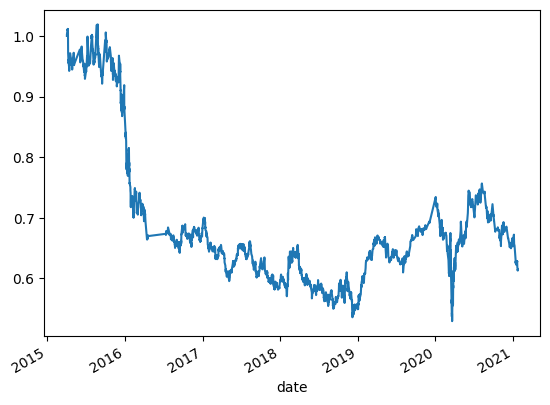

In [64]:
# Plot Strategy Returns to examine performance
(1 + signals_df['Strategy Returns']).cumprod().plot()

### Step 3: Split the data into training and testing datasets.

In [65]:
# Assign a copy of the sma_fast and sma_slow columns to a features DataFrame called X
X = signals_df[['SMA_Fast', 'SMA_Slow']].shift().dropna()

# Review the DataFrame
X.head()

,SMA_Fast,SMA_Slow
date,,
2015-04-02 15:00:00,24.9175,24.3214
2015-04-02 15:15:00,24.9200,24.3308
2015-04-02 15:30:00,24.9250,24.3360
2015-04-02 15:45:00,24.9325,24.3411
2015-04-06 09:30:00,24.9475,24.3463


In [66]:
#z=signals_df['SMA_Fast', 'SMA_Slow'].shift().dropna()


In [67]:
# Create the target set selecting the Signal column and assiging it to y
y = signals_df['Signal']
display(y.head())
# Review the value counts
display(y.value_counts())

date
2015-04-02 14:45:00    1.0
2015-04-02 15:00:00    1.0
2015-04-02 15:15:00    1.0
2015-04-02 15:30:00    1.0
2015-04-02 15:45:00    1.0
Name: Signal, dtype: float64

 1.0    2368
-1.0    1855
Name: Signal, dtype: int64

In [68]:
y.head()

date
2015-04-02 14:45:00    1.0
2015-04-02 15:00:00    1.0
2015-04-02 15:15:00    1.0
2015-04-02 15:30:00    1.0
2015-04-02 15:45:00    1.0
Name: Signal, dtype: float64

In [69]:
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

2015-04-02 15:00:00


In [70]:
# Select the ending period for the training data with an offset of 3 months
training_end = X.index.min() + DateOffset(months=6)

# Display the training end date
print(training_end)

2015-10-02 15:00:00


In [71]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Review the X_train DataFrame
display(X_train.head())
display(X_train.tail())

,SMA_Fast,SMA_Slow
date,,
2015-04-02 15:00:00,24.9175,24.3214
2015-04-02 15:15:00,24.9200,24.3308
2015-04-02 15:30:00,24.9250,24.3360
2015-04-02 15:45:00,24.9325,24.3411
2015-04-06 09:30:00,24.9475,24.3463


,SMA_Fast,SMA_Slow
date,,
2015-09-30 14:45:00,21.4800,21.6888
2015-10-02 09:30:00,21.2325,21.6672
2015-10-02 10:30:00,20.9875,21.6465
2015-10-02 11:30:00,20.7775,21.6293
2015-10-02 14:45:00,20.9450,21.6144


In [72]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end+DateOffset(hours=1):]
y_test = y.loc[training_end+DateOffset(hours=1):]

# Review the X_test DataFrame
display(X_test.head())
display(X_test.tail())

,SMA_Fast,SMA_Slow
date,,
2015-10-05 09:45:00,21.42725,21.56409
2015-10-05 11:30:00,21.53225,21.55469
2015-10-05 13:15:00,21.60250,21.54289
2015-10-05 14:30:00,21.66750,21.53089
2015-10-05 14:45:00,21.75250,21.51939


,SMA_Fast,SMA_Slow
date,,
2021-01-22 09:30:00,33.1725,30.36035
2021-01-22 11:30:00,33.2025,30.40215
2021-01-22 13:45:00,33.2725,30.44445
2021-01-22 14:30:00,33.3850,30.48745
2021-01-22 15:45:00,33.3775,30.53085


In [73]:
y_test.head()

date
2015-10-05 09:45:00    1.0
2015-10-05 11:30:00    1.0
2015-10-05 13:15:00   -1.0
2015-10-05 14:30:00    1.0
2015-10-05 14:45:00    1.0
Name: Signal, dtype: float64

In [74]:
# Scale the features DataFrames

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

### Step 4: Use the `SVC` classifier model from SKLearn's support ve
ctor machine (SVM) learning method to fit the training data and make predictions based on the testing data. Review the predictions.

In [75]:
# From SVM, instantiate SVC classifier model instance
from sklearn.svm import SVC
svm_model =SVC() # YOUR CODE HERE
 
# Fit the model to the data using the training data
svm_model = svm_model.fit(X_train,y_train)# YOUR CODE HERE
 
# Use the testing data to make the model predictions
svm_pred = svm_model.predict(X_test)# YOUR CODE HERE

# Review the model's predicted values
# YOUR CODE HERE
display(svm_pred)

array([1., 1., 1., ..., 1., 1., 1.])

### Step 5: Review the classification report associated with the `SVC` model predictions. 

In [76]:
# Use a classification report to evaluate the model using the predictions and testing data
svm_testing_report = classification_report(y_test, svm_pred)# YOUR CODE HERE

# Print the classification report
# YOUR CODE HERE
print(svm_testing_report)

              precision    recall  f1-score   support

        -1.0       0.44      0.20      0.28      1732
         1.0       0.56      0.80      0.66      2211

    accuracy                           0.54      3943
   macro avg       0.50      0.50      0.47      3943
weighted avg       0.51      0.54      0.49      3943



Accuracy value close to 50% is typically not good--basically random like a coin flip. There is some evidence in the imbalanced f1 ratios suggesting equal supports through resampling could improve metrics. Also see that the recall for one class is really high while low for another class, suggesting that the test is overly aggressive or biased for the 1.0 classification

In [77]:
signals_df

,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
date,,,,,,
2015-04-02 14:45:00,24.92,0.000000,24.9175,24.32140,1.0,NaN
2015-04-02 15:00:00,24.92,0.000000,24.9200,24.33080,1.0,0.000000
2015-04-02 15:15:00,24.94,0.000803,24.9250,24.33600,1.0,0.000803
2015-04-02 15:30:00,24.95,0.000401,24.9325,24.34110,1.0,0.000401
2015-04-02 15:45:00,24.98,0.001202,24.9475,24.34630,1.0,0.001202
...,...,...,...,...,...,...
2021-01-22 09:30:00,33.27,-0.006866,33.2025,30.40215,-1.0,-0.006866
2021-01-22 11:30:00,33.35,0.002405,33.2725,30.44445,1.0,-0.002405
2021-01-22 13:45:00,33.42,0.002099,33.3850,30.48745,1.0,0.002099


### Step 6: Create a predictions DataFrame that contains columns for “Predicted” values, “Actual Returns”, and “Strategy Returns”.

In [78]:

# Create a new empty predictions DataFrame.

# Create a predictions DataFrame
predictions_df = pd.DataFrame(index=X_test.index)
# YOUR CODE HERE

# Add the SVM model predictions to the DataFrame
predictions_df['Predicted'] = svm_pred# YOUR CODE HERE

# Add the actual returns to the DataFrame
predictions_df['Actual Returns'] = signals_df['Actual Returns']# YOUR CODE HERE

# Add the strategy returns to the DataFrame
predictions_df['Strategy Returns'] = signals_df['Actual Returns']*predictions_df['Predicted']# YOUR CODE HERE

# Review the DataFrame
display(predictions_df.head(100))
display(predictions_df.tail())

,Predicted,Actual Returns,Strategy Returns
date,,,
2015-10-05 09:45:00,1.0,0.013532,0.013532
2015-10-05 11:30:00,1.0,0.002302,0.002302
2015-10-05 13:15:00,1.0,-0.000919,-0.000919
2015-10-05 14:30:00,1.0,0.000920,0.000920
2015-10-05 14:45:00,1.0,0.002756,0.002756
...,...,...,...
2015-11-17 12:15:00,1.0,-0.001376,-0.001376
2015-11-17 13:15:00,1.0,-0.000459,-0.000459
2015-11-17 14:00:00,1.0,-0.000919,-0.000919


,Predicted,Actual Returns,Strategy Returns
date,,,
2021-01-22 09:30:00,1.0,-0.006866,-0.006866
2021-01-22 11:30:00,1.0,0.002405,0.002405
2021-01-22 13:45:00,1.0,0.002099,0.002099
2021-01-22 14:30:00,1.0,0.001496,0.001496
2021-01-22 15:45:00,1.0,-0.000896,-0.000896


### Step 7: Create a cumulative return plot that shows the actual returns vs. the strategy returns. Save a PNG image of this plot. This will serve as a baseline against which to compare the effects of tuning the trading algorithm.

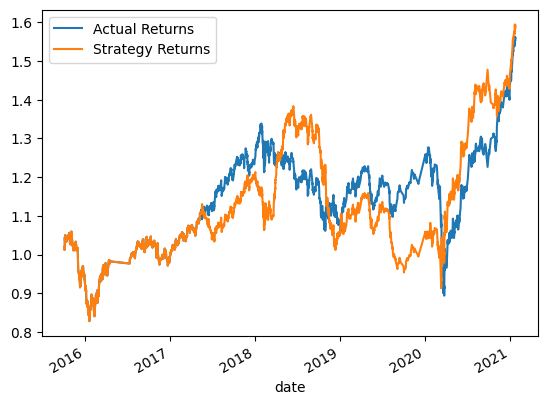

In [79]:
# Plot the actual returns versus the strategy returns
# YOUR CODE HERE
#plot=predictions_df['Actual Returns'].hvplot()*predictions_df['Strategy Returns'].hvplot()
plot=(1+predictions_df[['Actual Returns','Strategy Returns']]).cumprod().plot()
#plot.save('returns.png', fmt='png')
plot.figure.savefig('svc_6-month.png')

To understand the plots, we must understand that for any given date, the strategy returns values and actual returns values are equal in magnitude. They just might differ in sign.

---

## Tune the Baseline Trading Algorithm

## Step 6: Use an Alternative ML Model and Evaluate Strategy Returns

In this section, you’ll tune, or adjust, the model’s input features to find the parameters that result in the best trading outcomes. You’ll choose the best by comparing the cumulative products of the strategy returns.

### Step 1: Tune the training algorithm by adjusting the size of the training dataset. 

To do so, slice your data into different periods. Rerun the notebook with the updated parameters, and record the results in your `README.md` file. 

Answer the following question: What impact resulted from increasing or decreasing the training window?

### Step 2: Tune the trading algorithm by adjusting the SMA input features. 

Adjust one or both of the windows for the algorithm. Rerun the notebook with the updated parameters, and record the results in your `README.md` file. 

Answer the following question: What impact resulted from increasing or decreasing either or both of the SMA windows?

### Step 3: Choose the set of parameters that best improved the trading algorithm returns. 

Save a PNG image of the cumulative product of the actual returns vs. the strategy returns, and document your conclusion in your `README.md` file.

---

## Evaluate a New Machine Learning Classifier

In this section, you’ll use the original parameters that the starter code provided. But, you’ll apply them to the performance of a second machine learning model. 

### Step 1:  Import a new classifier, such as `AdaBoost`, `DecisionTreeClassifier`, or `LogisticRegression`. (For the full list of classifiers, refer to the [Supervised learning page](https://scikit-learn.org/stable/supervised_learning.html) in the scikit-learn documentation.)

In [80]:
# Import a new classifier from SKLearn
# YOUR CODE HERE
from sklearn.ensemble import AdaBoostClassifier

# Initiate the model instance
ada_clf=AdaBoostClassifier(n_estimators=100)
ada_model=ada_clf.fit(X_train,y_train)
ada_clf_pred = ada_model.predict(X_test)
# YOUR CODE HERE
display(ada_clf_pred)
ada_testing_report = classification_report(y_test, ada_clf_pred)# YOUR CODE HERE

print(ada_testing_report)

array([ 1.,  1.,  1., ..., -1., -1., -1.])

              precision    recall  f1-score   support

        -1.0       0.44      0.48      0.46      1732
         1.0       0.56      0.52      0.54      2211

    accuracy                           0.50      3943
   macro avg       0.50      0.50      0.50      3943
weighted avg       0.51      0.50      0.50      3943



### Step 2: Using the original training data as the baseline model, fit another model with the new classifier.

In [81]:
print("completed in previous cell")
print("steps 1-2 combined in last cell")

completed in previous cell
steps 1-2 combined in last cell


### Step 3: Backtest the new model to evaluate its performance. 

Save a PNG image of the cumulative product of the actual returns vs. the strategy returns for this updated trading algorithm, and write your conclusions in your `README.md` file. 

Answer the following questions: 
Did this new model perform better or worse than the provided baseline model? 
Did this new model perform better or worse than your tuned trading algorithm?

In [82]:
# Use a classification report to evaluate the model using the predictions and testing data
# YOUR CODE HERE
ada_testing_report = classification_report(y_test, ada_clf_pred)# YOUR CODE HERE

# Print the classification report
# YOUR CODE HERE
print(ada_testing_report)


              precision    recall  f1-score   support

        -1.0       0.44      0.48      0.46      1732
         1.0       0.56      0.52      0.54      2211

    accuracy                           0.50      3943
   macro avg       0.50      0.50      0.50      3943
weighted avg       0.51      0.50      0.50      3943



In [83]:
# Create a new empty predictions DataFrame.
df=pd.DataFrame(index=X_test.index)
# Create a predictions DataFrame
# YOUR CODE HERE
df['Predicted'] = ada_clf_pred
# Add the SVM model predictions to the DataFrame
# YOUR CODE HERE
df['svm predictions'] = svm_pred


# Add the actual returns to the DataFrame
# YOUR CODE HERE
df['Actual Returns'] = signals_df['Actual Returns']
# Add the strategy returns to the DataFrame
df['strategy returns']=signals_df['Actual Returns']*df['Predicted']
# YOUR CODE HERE

# Review the DataFrame
# YOUR CODE HERE
display(df.head(20))
display(df.tail(500))

,Predicted,svm predictions,Actual Returns,strategy returns
date,,,,
2015-10-05 09:45:00,1.0,1.0,0.013532,0.013532
2015-10-05 11:30:00,1.0,1.0,0.002302,0.002302
2015-10-05 13:15:00,1.0,1.0,-0.000919,-0.000919
2015-10-05 14:30:00,1.0,1.0,0.000920,0.000920
2015-10-05 14:45:00,1.0,1.0,0.002756,0.002756
2015-10-05 15:45:00,1.0,1.0,-0.002290,-0.002290
2015-10-06 10:00:00,1.0,1.0,0.003214,0.003214
2015-10-06 15:30:00,1.0,1.0,-0.005034,-0.005034
2015-10-06 15:45:00,1.0,1.0,-0.001380,-0.001380


,Predicted,svm predictions,Actual Returns,strategy returns
date,,,,
2020-03-04 11:30:00,1.0,1.0,0.001990,0.001990
2020-03-05 11:45:00,1.0,1.0,0.001192,0.001192
2020-03-05 12:45:00,1.0,1.0,-0.006349,-0.006349
2020-03-05 14:00:00,1.0,1.0,0.001198,0.001198
2020-03-05 14:15:00,1.0,1.0,-0.002792,-0.002792
...,...,...,...,...
2021-01-22 09:30:00,-1.0,1.0,-0.006866,0.006866
2021-01-22 11:30:00,-1.0,1.0,0.002405,-0.002405
2021-01-22 13:45:00,-1.0,1.0,0.002099,-0.002099


<AxesSubplot: xlabel='date'>

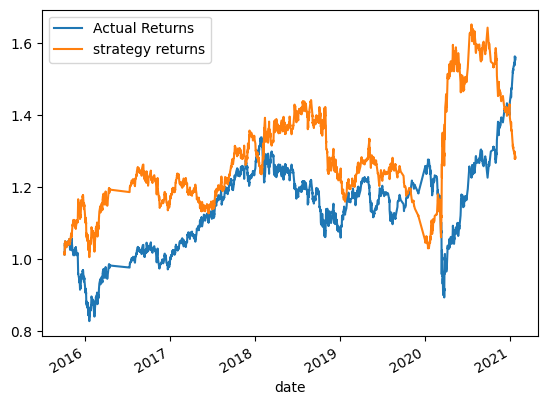

In [84]:
# Plot the actual returns versus the strategy returns
(1+df[['Actual Returns','strategy returns']]).cumprod().plot()


This marks an improvement over the SVM returns, especially from 2020-2021

**Trying the Multi-Layer Perceptron Classifier**

In [85]:
from sklearn.neural_network import MLPClassifier

mlp_clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(15,), random_state=1)
mlp_model=mlp_clf.fit(X_train,y_train)
mlp_pred=mlp_model.predict(X_test)
display(mlp_pred)


array([1., 1., 1., ..., 1., 1., 1.])

In [86]:
# Use a classification report to evaluate the model using the predictions and testing data
mlp_testing_report = classification_report(y_test, mlp_pred)# YOUR CODE HERE

# Print the classification report
# YOUR CODE HERE
print(mlp_testing_report)

              precision    recall  f1-score   support

        -1.0       0.55      0.03      0.05      1732
         1.0       0.56      0.98      0.72      2211

    accuracy                           0.56      3943
   macro avg       0.55      0.50      0.38      3943
weighted avg       0.56      0.56      0.42      3943



In [87]:
X_train

,SMA_Fast,SMA_Slow
date,,
2015-04-02 15:00:00,24.9175,24.3214
2015-04-02 15:15:00,24.9200,24.3308
2015-04-02 15:30:00,24.9250,24.3360
2015-04-02 15:45:00,24.9325,24.3411
2015-04-06 09:30:00,24.9475,24.3463
...,...,...
2015-09-30 14:45:00,21.4800,21.6888
2015-10-02 09:30:00,21.2325,21.6672
2015-10-02 10:30:00,20.9875,21.6465


In [32]:
y_test

date
2015-04-29 12:45:00   -1.0
2015-04-30 10:30:00   -1.0
2015-04-30 11:00:00   -1.0
2015-04-30 13:15:00    1.0
2015-04-30 13:30:00    1.0
                      ... 
2021-01-22 09:30:00   -1.0
2021-01-22 11:30:00    1.0
2021-01-22 13:45:00    1.0
2021-01-22 14:30:00    1.0
2021-01-22 15:45:00   -1.0
Name: Signal, Length: 4159, dtype: float64